In [1]:
import tensorflow as tf
tf.__version__

'2.8.2'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


데이터 증강시키고 훈련해보기

In [3]:
import os, shutil
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models

In [4]:
import pickle
# 훈련데이터 불러오기

with open('/content/drive/Shareddrives/Deep Learning/2022-DL/OurTrainData.pkl', 'rb') as f:
  X_train, Y_train = pickle.load(f)
with open('/content/drive/Shareddrives/Deep Learning/2022-DL/OurTestData.pkl', 'rb') as f:
  X_test, Y_test = pickle.load(f)
print(X_train.shape, Y_train.shape)

(865, 28, 28) (865, 10)


In [5]:

# 이미지 데이터 크기 (28, 28, 1)로 reshape
X_train = X_train.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))
# 픽셀값을 0~1 범위로 정규화
if np.max(X_train > 1):
  X_train = X_train.astype('float32') / 255
if np.max(X_test > 1):
  X_test = X_test.astype('float32') / 255

print(X_train.shape, X_test.shape)

(865, 28, 28, 1) (200, 28, 28, 1)


In [6]:
X_train = np.concatenate([X_train , X_test])
Y_train = np.concatenate([Y_train , Y_test])

In [7]:
print(X_train.shape, Y_train.shape)

(1065, 28, 28, 1) (1065, 10)


In [8]:
# 훈련 데이터 무작위로 섞기
idx = np.arange(X_train.shape[0])
np.random.shuffle(idx)
X_train = X_train[idx]
Y_train = Y_train[idx]


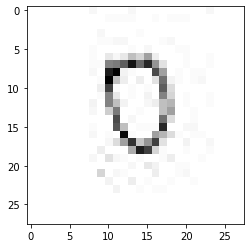

0.11764706


In [9]:
im =  np.squeeze(X_train[1])
plt.imshow(im, cmap='Greys')
plt.show()
print(np.max(X_train[1]))

In [10]:
BATCH_SIZE =5

In [11]:
def contrast_normalize(img):
  max = np.max(img)
  w = 1/max
  return w*img


In [12]:
train_datagen = ImageDataGenerator(width_shift_range=5,
                                    height_shift_range=5,
                                    rotation_range=30,
                                    zoom_range=0.3,
                                    validation_split=0.2,
                                    preprocessing_function=contrast_normalize)


In [13]:
train_generator = train_datagen.flow(
        X_train,
        Y_train,
        batch_size=BATCH_SIZE,
        subset='training')
val_generator = train_datagen.flow(
        X_train,
        Y_train,
        batch_size=BATCH_SIZE,
        subset='validation')

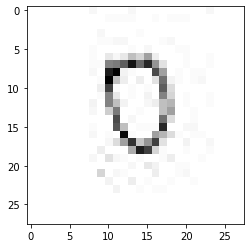

0.11764706


In [14]:
im =  np.squeeze(X_train[1])
plt.imshow(im, cmap='Greys')
plt.show()
print(np.max(X_train[1]))

(5, 10)
label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


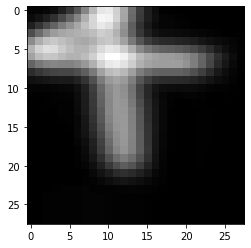

1.0 0.0


In [15]:
x_train, y_train = train_generator.next()
print(y_train.shape)
for i in range(1):
  print('label:', y_train[i])
  im = np.squeeze(x_train[i])
  plt.imshow(im, cmap='gray')
  plt.show()
  print(np.max(im), np.min(im))

(5, 10)
label: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


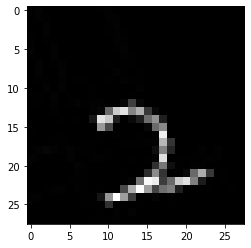

1.0 0.0


In [16]:
x_val, y_val = val_generator.next()
print(y_val.shape)
for i in range(1):
  print('label:', y_val[i])
  im = np.squeeze(x_val[i])
  plt.imshow(im, cmap='gray')
  plt.show()
  print(np.max(im), np.min(im))

## **모델 설정

In [140]:
# 모델 구성

model2 = models.Sequential()
model2.add(layers.Conv2D(16, (5,5), activation="relu", input_shape=(28, 28, 1), kernel_initializer='he_uniform'))
model2.add(layers.Dropout(0.2))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Conv2D(32, (3,3), activation="relu", kernel_initializer='he_uniform'))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Conv2D(32, (3,3), activation="relu", kernel_initializer='he_uniform'))
model2.add(layers.Dropout(0.2))
model2.add(layers.Flatten())
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(10, activation='softmax'))
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 24, 24, 16)        416       
                                                                 
 dropout_8 (Dropout)         (None, 24, 24, 16)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 10, 10, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 3, 3, 32)         

In [141]:
opt = tf.optimizers.RMSprop(learning_rate=0.001)
model2.compile(optimizer = opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [142]:
# 파라미터

BATCH_SIZE = 5 # 배치 크기
ITER = 170 # 한 epoch에 배치를 몇개 처리할 건지
EPOCHS = 60 # 전체 데이터에 대한 훈련 수( 50~60 )
VAL_STEPS = 20 # 몇 번에 한번 검증할 건지

In [143]:
history = model2.fit(
      train_generator,
      steps_per_epoch=ITER,
      epochs=EPOCHS,
      validation_data=val_generator,
      validation_steps=VAL_STEPS)

Epoch 1/60
170/170 [==============================] - 2s 7ms/step - loss: 2.2737 - accuracy: 0.1452 - val_loss: 2.1609 - val_accuracy: 0.2200
Epoch 2/60
170/170 [==============================] - 1s 6ms/step - loss: 2.0838 - accuracy: 0.2562 - val_loss: 1.9485 - val_accuracy: 0.3500
Epoch 3/60
170/170 [==============================] - 1s 6ms/step - loss: 1.9008 - accuracy: 0.3388 - val_loss: 1.8576 - val_accuracy: 0.3800
Epoch 4/60
170/170 [==============================] - 1s 6ms/step - loss: 1.7464 - accuracy: 0.3955 - val_loss: 1.7230 - val_accuracy: 0.4200
Epoch 5/60
170/170 [==============================] - 1s 6ms/step - loss: 1.6794 - accuracy: 0.4168 - val_loss: 1.8469 - val_accuracy: 0.3500
Epoch 6/60
170/170 [==============================] - 1s 6ms/step - loss: 1.5673 - accuracy: 0.4604 - val_loss: 1.5877 - val_accuracy: 0.4900
Epoch 7/60
170/170 [==============================] - 1s 6ms/step - loss: 1.4578 - accuracy: 0.5089 - val_loss: 1.4554 - val_accuracy: 0.5100
Epoch 

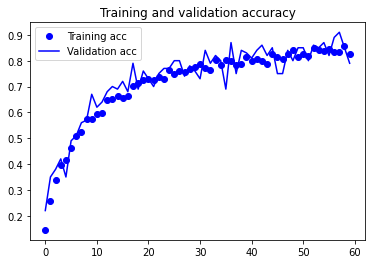

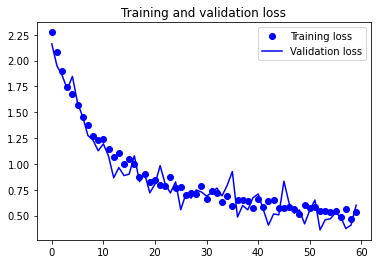

In [144]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [222]:
import time
from datetime import datetime
dtime = datetime.fromtimestamp(time.time())
savefile = 'OurCNN_'+str(dtime)+'.h5'
model2.save(savefile)

In [221]:
model2.fit(train_images, train_labels, epochs=3, batch_size=64)

Epoch 1/3
938/938 [==============================] - 5s 5ms/step - loss: 0.1183 - accuracy: 0.9661
Epoch 2/3
938/938 [==============================] - 4s 5ms/step - loss: 0.0606 - accuracy: 0.9815
Epoch 3/3
938/938 [==============================] - 4s 5ms/step - loss: 0.0480 - accuracy: 0.9858


In [223]:
model2 = load_model(savefile)

In [29]:
# MNIST 데이터셋 임포트
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

11501568/11490434 [==============================] - 0s 0us/step


In [162]:
test_loss, test_acc = model2.evaluate(test_images, test_labels)
test_acc

313/313 [==============================] - 1s 3ms/step - loss: 0.0259 - accuracy: 0.9919


0.9919000267982483

In [32]:
!pip3 install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 7.9 MB/s 


In [33]:
import pickle5 as pickle

In [34]:
with open('/content/drive/Shareddrives/Deep Learning/2022-DL/testdata2D_N.pkl', 'rb') as f:
  X_test_f, Y_test_f = pickle.load(f)

X_test_f = X_test_f.reshape((-1, 28, 28, 1))

num = np.unique(Y_test_f, axis=0)
num = num.shape[0]

Y_test_f = np.eye(num)[Y_test_f]

print(X_test_f.shape, Y_test_f.shape)

(429, 28, 28, 1) (429, 10)


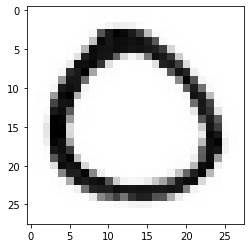

0.9372549
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [35]:
im =  np.squeeze(X_test_f[1])
plt.imshow(im, cmap='Greys')
plt.show()
print(np.max(X_test_f[1]))
print(Y_test_f[1])

In [224]:

print("-- Evaluate --")
scores = model2.evaluate(X_test_f, Y_test_f)
print("%s: %.2f%%" %(model2.metrics_names[1], scores[1]*100))

wrong_predict = []
for i in range(10):
  wrong_predict.append([])


-- Evaluate --
14/14 [==============================] - 0s 3ms/step - loss: 0.3698 - accuracy: 0.9324
accuracy: 93.24%


In [137]:
print("-- Predict --")
y_pred = model2.predict(X_test_f)
for i in range(len(X_test_f)):
  predict = np.argmax(y_pred[i])
  y_true = np.argmax(Y_test_f[i])
  if predict != y_true:
    wrong_predict[y_true].append(predict)
for idx, pred in enumerate(wrong_predict):
  print(idx,'에 대한 오답 수:', len(pred))
  if pred:
    print(' - 오답들: ', pred)
  print()

-- Predict --
0 에 대한 오답 수: 0

1 에 대한 오답 수: 1
 - 오답들:  [2]

2 에 대한 오답 수: 1
 - 오답들:  [1]

3 에 대한 오답 수: 0

4 에 대한 오답 수: 5
 - 오답들:  [8, 8, 8, 8, 8]

5 에 대한 오답 수: 0

6 에 대한 오답 수: 1
 - 오답들:  [5]

7 에 대한 오답 수: 0

8 에 대한 오답 수: 0

9 에 대한 오답 수: 17
 - 오답들:  [7, 7, 7, 7, 3, 3, 7, 7, 2, 7, 7, 7, 7, 7, 7, 7, 4]

